In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from utils.empirical_data import *
from mechanisms.mldp.mldp import *
from mechanisms.k_rr.k_rr_mechanism import *
from mechanisms.mldp.repetitive_optimizer import *
from utils.synthetic_dataset import *
from mechanisms.exponential.exponential_mechanism import *
from utils.simpleinfotheory import *
from utils.normalize_error_matrix import *
from mechanisms.rappor.rappor_mechanism import *


import matplotlib as mpl
import matplotlib.lines as mlines


mpl.rcParams.update({'font.size': 10})

In [2]:
from sympy import symbols, Eq, solve
import sympy


def cal_eps_values(eps):
    eps_list = []
    c = np.exp(eps)
    print(c)
    symbol_string = ""
    for i in range(NUM_ATTRIBUTES):
        symbol_string += chr(97+i) + " "
    
    local_eps_values = symbols(symbol_string)
    eqn_list = []
    for i in range(NUM_ATTRIBUTES):
        eqn = 1
        for j in range(NUM_ATTRIBUTES):
            if i == j:
                eqn *= sympy.exp(local_eps_values[j])
            else:
                max_ = joint_prob_dict[str(i)+" "+str(j)][0]
                min_ = joint_prob_dict[str(i)+" "+str(j)][1]
                print(max_, min_)
                eqn *= (1 + (sympy.exp(local_eps_values[j])-1)*max_)/(1 + (sympy.exp(local_eps_values[j])-1)*min_)
        eq1 = Eq(eqn, c)
        eqn_list.append(eq1)
        # Solve the equations for a and b
    solution = solve(eqn_list, local_eps_values)
    # real_solutions = [sol.evalf() for sol in solution if sol.is_real]
    return [float(i) for i in solution[0]]

In [3]:
from utils.alphabet import *

NUM_ATTRIBUTES = 2
NUM_STATES = [5, 5]
DATASET_SIZE = 20000

priority_dict = {} # {'0': 2, '1': 0.5}

TOTAL_STATES = 1
alphabet_dict = {}
for i in range(NUM_ATTRIBUTES):
    TOTAL_STATES *= NUM_STATES[i]
    alphabet_dict[str(i)] = np.arange(NUM_STATES[i])

ALL_ALPHABET = create_alphabet(attributes_with_alphabet=alphabet_dict)
STRING_ALL_ALPHABET = convert_alphabet_to_string(ALL_ALPHABET)
ATTRIBUTE_LIST = list(alphabet_dict.keys())

mi = 0
max_mi = 0
variance = 35
entropy_ = entropy_2 = 1
while mi/min(entropy_, entropy_2) < 0.6 or mi/min(entropy_, entropy_2) > 0.7: # or entropy_ < 1.7 or entropy_2 <1.7:
    # random_dist = np.ones(TOTAL_STATES) + np.array([abs((np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1))[0]) for i in range(TOTAL_STATES)]) # np.ones(TOTAL_STATES) #
    # random_dist = np.array([abs((np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1))[0]) for i in range(TOTAL_STATES)]) # np.ones(TOTAL_STATES) #
    # random_dist = np.array([0.332, 0.001, 0.001, 0.001, 0.332, 0.001, 0.001, 0.001, 0.33])
    random_dist = np.ones(TOTAL_STATES)*5 + np.absolute(np.random.normal(1, variance, TOTAL_STATES)*np.random.normal(1, variance, TOTAL_STATES)) # np.array([abs((np.random.normal(1, variance, 1)*np.random.normal(1, variance, 1))[0]) for i in range(TOTAL_STATES)]) # np.ones(TOTAL_STATES) #
    random_dist = random_dist/np.sum(random_dist)
    
    p = (np.reshape(random_dist, (NUM_STATES[0], NUM_STATES[1])))
    mi = mutualinformation(p)
    entropy_ = entropy(np.sum(p, axis=1))
    entropy_2 = entropy(np.sum(p, axis=0))
    # break
    if mi >= max_mi:
        max_mi = mi
        print("mi ", mi, mi/min(entropy_, entropy_2), entropy_, entropy_2) 
        # break
print("mi ", mi, mi/min(entropy_, entropy_2), entropy_, entropy_2) 
synthetic_dataset_constructor = Gen_Synthetic_Dataset(no_of_states = TOTAL_STATES, no_of_samples = DATASET_SIZE, alphabet=STRING_ALL_ALPHABET)
correlated_synthetic_dataset = synthetic_dataset_constructor.gen_custom(distribution=random_dist)
entropy_ = entropy(np.sum(p, axis=1))
entropy_2 = entropy(np.sum(p, axis=0))
sns.heatmap(p, vmax=1, vmin=0)
plt.show()
print(entropy(np.sum(p, axis=1)))
print(entropy(np.sum(p, axis=0)))
print(random_dist)
print(correlated_synthetic_dataset)

joint_prob_dict = {}
for i in range(NUM_ATTRIBUTES):
    for j in range(NUM_ATTRIBUTES):
        if i==j:
            continue
        
        joint_prob_matrix = np.zeros((NUM_STATES[i], NUM_STATES[j]))
        for ii in range(NUM_STATES[i]):
            for jj in range(NUM_STATES[j]):
                joint_prob_ = 0
                for k in range(len(ALL_ALPHABET)):
                    if ALL_ALPHABET[k][i] == ii and ALL_ALPHABET[k][j] == jj:
                        joint_prob_ += random_dist[k]
                joint_prob_matrix[ii][jj] = joint_prob_  
        
        conditional_prob = joint_prob_matrix/np.reshape(np.sum(joint_prob_matrix, axis=0), (1,-1))
        # max_val = max(np.max(conditional_prob, axis=1) - np.min(conditional_prob, axis=1))
        print("joint", joint_prob_matrix, p)
        print(conditional_prob)
        sns.heatmap(conditional_prob, vmax=1, vmin=0, annot=True)
        plt.show()
        # print(np.max(conditional_prob, axis=1) - np.min(conditional_prob, axis=1), max_val)
        # row_num = np.argmax(np.max(conditional_prob, axis=1) - np.min(conditional_prob, axis=1))
        # joint_prob_dict[str(i)+" "+str(j)] = (np.max(conditional_prob[row_num]), np.min(conditional_prob[row_num]))
        joint_prob_dict[str(i)+" "+str(j)] = (np.mean(np.max(conditional_prob, axis=1)), np.mean(np.min(conditional_prob, axis=1)))
        print(joint_prob_dict[str(i)+" "+str(j)])

mi  0.34267181520351464 0.157573705740822 2.1746763750491653 2.2336743785568776
mi  0.541614483335648 0.25986951251428403 2.1070766105348158 2.0841786252470746
mi  0.5844411833097629 0.26445485884856124 2.2099846675323906 2.2709967188540885
mi  0.6023626262141479 0.26945020247324747 2.260953812794583 2.2355248601973265
mi  0.643792280482014 0.31154499982887873 2.2739103535297343 2.066450371007808
mi  0.9023031633130194 0.4192528661595495 2.2392342813000248 2.1521693377515083
mi  0.9577692197476932 0.47011033578584377 2.2026019164787805 2.0373285734011173
mi  1.054858777624426 0.5096835755542851 2.1699573961705916 2.069634628656139
mi  1.0997076490793312 0.4915547714403273 2.2372026739909923 2.278012856289917
mi  1.1600027667760524 0.5402498971032824 2.1728727521941367 2.147159625565442


KeyboardInterrupt: 

In [ ]:
def mutual_info_pair(a, b):
    return mutualinformationempirical(xn=a, yn=b)[0]

# I(A;A',B') = I(A;A') + I(A;B'|A')

def conditional_mutual_info(a, b, c):
    return conditionalmutualinformationempirical(a, b, c)

def total_info_leakage(A, A_prime, B_prime):
    return mutual_info_pair(A, A_prime) + conditional_mutual_info(A, B_prime, A_prime)
    # return  mutual_info_pair(A, B_prime) - conditional_mutual_info(A, B_prime, A_prime)

def total_info_leakage2(A, A_prime, B_prime):
    return mutual_info_pair(A, A_prime)# + conditional_mutual_info(A, B_prime, A_prime)

def mutual_information(a, b):
    processed_a = []
    # print(a)
    # print(b)
    for i in a:
        actual_split = i.split(" ")
        actual = []
        # print(actual_split)
        for j in actual_split:
            # print(i)
            if j != "" :
                actual.append(int(j))
        processed_a.append(np.array(actual))
    processed_a = np.array(processed_a)
    processed_b = []
    
    for i in b:
        actual_split = i.split(" ")
        actual = []
        # print(actual_split)
        for j in actual_split:
            # print(i)
            if j != "" :
                actual.append(int(j))
        processed_b.append(np.array(actual))
    processed_b = np.array(processed_b)

    mi = []
    # print("processed_a", processed_a)
    # print("processed_b", processed_b)
    # for i in range(np.shape(processed_b)[1]):
    #     mi.append(mutual_info_pair(processed_a[:,i], processed_b[:,i]))
    # mi.append(mutual_info_pair(processed_a[:,0], processed_a[:,1]))
    # mi.append(mutual_info_pair(processed_b[:,1], processed_b[:,0]))
    # mi.append(mutual_info_pair(processed_a[:,0], processed_b[:,0]))
    # mi.append(mutual_info_pair(processed_a[:,1], processed_b[:,1]))


    mi.append(total_info_leakage(processed_a[:,0], processed_b[:,0], processed_b[:,1]))
    mi.append(total_info_leakage2(processed_a[:,0], processed_b[:,0], processed_b[:,1]))

    # mi.append(total_info_leakage(processed_a[:,1], processed_b[:,1], processed_b[:,0]))
    # mi.append(total_info_leakage2(processed_a[:,1], processed_b[:,1], processed_b[:,0]))


    # mi.append(total_info_leakage(processed_a[:,1], processed_b[:,1], processed_b[:,0]))
    # mi.append(total_info_leakage(processed_a[:,0], processed_b[:,1], processed_b[:,0]))
    return mi

def mutual_information2(a, b):
    processed_a = []
    # print(a)
    # print(b)
    for i in a:
        actual_split = i.split(" ")
        actual = []
        # print(actual_split)
        for j in actual_split:
            # print(i)
            if j != "" :
                actual.append(int(j))
        processed_a.append(np.array(actual))
    processed_a = np.array(processed_a)
    processed_b = []
    
    for i in b:
        actual_split = i.split(" ")
        actual = []
        # print(actual_split)
        for j in actual_split:
            # print(i)
            if j != "" :
                actual.append(int(j))
        processed_b.append(np.array(actual))
    processed_b = np.array(processed_b)

    mi = []
    mi.append(total_info_leakage2(processed_a[:,0], processed_b[:,0], processed_b[:,1]))
    return mi


In [ ]:
EPS_ARRAY = np.arange(1,16)*0.9#np.arange(50)*0.15

alphabet  25 [[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]
 [1 0]
 [1 1]
 [1 2]
 [1 3]
 [1 4]
 [2 0]
 [2 1]
 [2 2]
 [2 3]
 [2 4]
 [3 0]
 [3 1]
 [3 2]
 [3 3]
 [3 4]
 [4 0]
 [4 1]
 [4 2]
 [4 3]
 [4 4]]
alphabet_dict  2 {'0': array([0, 1, 2, 3, 4]), '1': array([0, 1, 2, 3, 4])}
prior_dist  25 [0.0282774  0.02838548 0.03549199 0.08554278 0.03044377 0.04502794
 0.02888457 0.04558865 0.02980393 0.10843698 0.02947894 0.04512201
 0.02923197 0.03799471 0.02988277 0.02845752 0.03819146 0.05901962
 0.02918817 0.03564867 0.03452083 0.03024518 0.04739738 0.02891358
 0.03082371]
individual_alphabet  ['0', '1', '2', '3', '4']


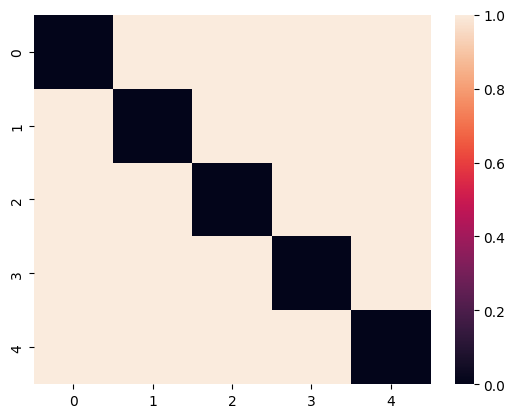

conditional_prior_dist  5 [0.20814142 0.25774207 0.1717104  0.19050543 0.17190068]
individual_alphabet  ['0', '1', '2', '3', '4']


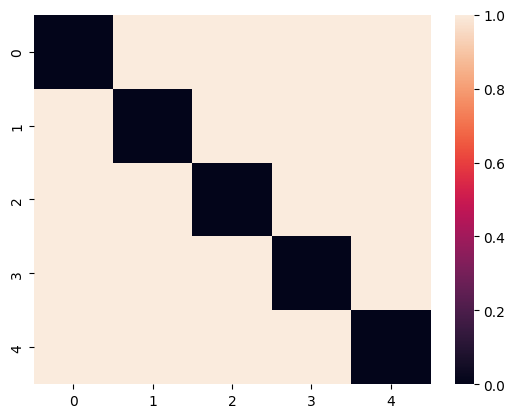

conditional_prior_dist  5 [0.13585669 0.13637594 0.17051863 0.41098393 0.14626481]
conditional_prior_dist  5 [0.17470155 0.11206775 0.17687703 0.1156347  0.42071898]
conditional_prior_dist  5 [0.17167824 0.2627797  0.17023995 0.22127207 0.17403005]
conditional_prior_dist  5 [0.14937903 0.2004744  0.30980542 0.15321435 0.1871268 ]
conditional_prior_dist  5 [0.20081844 0.17594565 0.27572537 0.16819936 0.17931118]


[{'0': <mechanisms.mldp.mldp.Optimized_Randomized_Response at 0x17ec0a3d0>},
 {'0 ': <mechanisms.mldp.mldp.Optimized_Randomized_Response at 0x17e3894c0>,
  '1 ': <mechanisms.mldp.mldp.Optimized_Randomized_Response at 0x17e325b20>,
  '2 ': <mechanisms.mldp.mldp.Optimized_Randomized_Response at 0x17e542670>,
  '3 ': <mechanisms.mldp.mldp.Optimized_Randomized_Response at 0x17e31eeb0>,
  '4 ': <mechanisms.mldp.mldp.Optimized_Randomized_Response at 0x17fe4ea90>}]

In [ ]:
def get_mechanism_key(predessor_index_list):
    __key = ""
    for i in predessor_index_list:
        __key += str(i) + " "
    return __key

def string_to_list(s):
    l = []
    actual_split = s.split(" ")
    for j in actual_split:
        if j != "" :
            l.append((j))
    return l

def get_conditional_dist(attribute_num, predessor_index_list, individual_alphabet, global_alphabet, prior_dist):
    __marginal_prob_dist = []
    k = len(predessor_index_list)
    # print("predessor_index_list ", predessor_index_list)
    for i in individual_alphabet:
        __marginal_prob = 0
        for index_j, j in enumerate(global_alphabet):
            # print("j[:k] ", j[:k], list(j[:k]) == list(predessor_index_list), j[attribute_num] == i, k == 0)
            if j[attribute_num] == i and (k == 0 or list(j[:k]) == list(predessor_index_list)):
                __marginal_prob += prior_dist[index_j]
        __marginal_prob_dist.append(__marginal_prob)
    return __marginal_prob_dist/sum(__marginal_prob_dist)


def create_optimal_mechnism_dict(alphabet = [], alphabet_dict = {}, prior_dist = [], err_type = "0_1", uniform = False):
    mechanism_list = []
    print("alphabet ", len(alphabet), alphabet)
    print("alphabet_dict ", len(alphabet_dict), alphabet_dict)
    print("prior_dist ", len(prior_dist), prior_dist)
    for i in range(NUM_ATTRIBUTES):
        mechanism_dict = {}
        individual_alphabet = alphabet_dict[str(i)]
        print("individual_alphabet ", convert_alphabet_to_string(individual_alphabet))
        state_count = len(individual_alphabet)
        normalize_error_matrix = Normalize_error_matrix(attribute_list=[str(i)], alphabet=individual_alphabet, priority_dict=priority_dict, alphabet_dict=alphabet_dict, err_type=err_type)
        err_matrix = normalize_error_matrix.normalized_error_matrix
        sns.heatmap(err_matrix)
        plt.show()
        for index_j, j in enumerate(alphabet):
            predessor_index_list = j[:i]
            if len(predessor_index_list) == 0:
                if uniform:
                    conditional_prior_dist = np.ones(len(individual_alphabet))/len(individual_alphabet)
                else:
                    conditional_prior_dist = get_conditional_dist(i, predessor_index_list, (individual_alphabet), alphabet, prior_dist)
                # err_matrix_1 = err_matrix*(1- conditional_prior_dist) #(1/(conditional_prior_dist+0.00000001))
                # err_matrix_1 = err_matrix_1 / np.max(err_matrix_1)
                # sns.heatmap(err_matrix_1)
                # plt.show()
                print("conditional_prior_dist ", len(conditional_prior_dist), conditional_prior_dist)
                # conditional_prior_dist = np.ones(len(conditional_prior_dist))/len(conditional_prior_dist)
                optimal_random_response_mechanism = Optimized_Randomized_Response(prior_dist = conditional_prior_dist, STATE_COUNT = state_count, INPUT_ALPHABET = convert_alphabet_to_string(individual_alphabet), normalized_objective_err_matrix = err_matrix, 
                    TOLERANCE_MARGIN = 0.01, APPROXIMATION = "LINEAR", solver = "SCS", is_kl_div = False, ALPHA=0.01, accelerate_from_rr=False)
                mechanism_dict["0"] = optimal_random_response_mechanism
                # sns.heatmap(optimal_random_response_mechanism.get_mechanism(2), annot=True)
                # plt.show()
                break
            __key = get_mechanism_key(predessor_index_list = predessor_index_list)
            # print(__key)
            if __key not in mechanism_dict.keys():
                if uniform:
                    conditional_prior_dist = np.ones(len(individual_alphabet))/len(individual_alphabet)
                else:
                    conditional_prior_dist = get_conditional_dist(i, predessor_index_list, (individual_alphabet), alphabet, prior_dist)
                # err_matrix_2 = err_matrix*(1- conditional_prior_dist) # *(1/(conditional_prior_dist+0.00000001))
                # err_matrix_2 = err_matrix_2 / np.max(err_matrix_2)
                # sns.heatmap(err_matrix_2)
                # plt.show()
                print("conditional_prior_dist ", len(conditional_prior_dist), conditional_prior_dist)
                # conditional_prior_dist = np.ones(len(conditional_prior_dist))/len(conditional_prior_dist)
                optimal_random_response_mechanism = Optimized_Randomized_Response(prior_dist = conditional_prior_dist, STATE_COUNT = state_count, INPUT_ALPHABET = convert_alphabet_to_string(individual_alphabet), normalized_objective_err_matrix = err_matrix, 
                    TOLERANCE_MARGIN = 0.01, APPROXIMATION = "LINEAR", solver = "SCS", is_kl_div = True, ALPHA=0.01, accelerate_from_rr=False)
                mechanism_dict[__key] = optimal_random_response_mechanism
                # sns.heatmap(optimal_random_response_mechanism.get_mechanism(2), annot=True)
                # plt.show()
        mechanism_list.append(mechanism_dict)
        # print("mechanism_list ", mechanism_list)
    return mechanism_list

def get_randomized_value(actual_value, eps, mechanism_list):
    actual_value = string_to_list(actual_value)
    last_value = None
    randomized_value_list = ""
    # print("actual_value ", actual_value)
    if not(isinstance(eps, list)):
        eps = [eps]*NUM_ATTRIBUTES
    # print("eps list ", eps)
    for index_i, i in enumerate(actual_value):
        if last_value == None:
            last_value = mechanism_list[index_i]["0"].gen_random_output(actual_value=i, eps=eps[index_i])[0]
        else:
            __key = randomized_value_list  #get_mechanism_key(predessor_index_list=randomized_value_list)
            last_value = mechanism_list[index_i][__key].gen_random_output(actual_value=i, eps=eps[index_i])[0]
        randomized_value_list += last_value + " "
    return randomized_value_list

            
create_optimal_mechnism_dict(alphabet=ALL_ALPHABET, alphabet_dict=alphabet_dict, prior_dist=random_dist, err_type="0_1")

In [ ]:
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, BicScore, MaximumLikelihoodEstimator
import networkx as nx

# data = pd.read_csv('adult.csv') #'list_attr_celeba.txt') #'adult.csv')

data = pd.read_csv('list_attr_celeba.txt', sep='\s+', engine='python', skiprows=1)

data.dropna(inplace=True)


In [ ]:
import random

attribute_list = list(data.columns)
priority_dict = {}

for i in attribute_list:
    priority_dict[i] = 1 # random.randint(1,10)/10
print(priority_dict)

# priority_dict = {"Young": 2, "Male": 5}
priority_dict_keys = priority_dict.keys()

black_list = []
for i in attribute_list:
    for j in attribute_list:
        if i == j:
            continue
        if i not in priority_dict_keys:
            i_priority = 1
        else:
            i_priority = priority_dict[i]

        if j not in priority_dict_keys:
            j_priority = 1
        else:
            j_priority = priority_dict[j]
        
        if i_priority < j_priority:
            black_list.append((i, j))

print(len(black_list), black_list)

{'[0 0]': 0, '[0 1]': 1, '[0 2]': 2, '[0 3]': 3, '[0 4]': 4, '[1 0]': 5, '[1 1]': 6, '[1 2]': 7, '[1 3]': 8, '[1 4]': 9, '[2 0]': 10, '[2 1]': 11, '[2 2]': 12, '[2 3]': 13, '[2 4]': 14, '[3 0]': 15, '[3 1]': 16, '[3 2]': 17, '[3 3]': 18, '[3 4]': 19, '[4 0]': 20, '[4 1]': 21, '[4 2]': 22, '[4 3]': 23, '[4 4]': 24}
alphabet  25 [[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]
 [1 0]
 [1 1]
 [1 2]
 [1 3]
 [1 4]
 [2 0]
 [2 1]
 [2 2]
 [2 3]
 [2 4]
 [3 0]
 [3 1]
 [3 2]
 [3 3]
 [3 4]
 [4 0]
 [4 1]
 [4 2]
 [4 3]
 [4 4]]
alphabet_dict  2 {'0': array([0, 1, 2, 3, 4]), '1': array([0, 1, 2, 3, 4])}
prior_dist  25 [0.01237882 0.0975662  0.00170614 0.14129748 0.0088159  0.0015002
 0.00324933 0.01909624 0.00089155 0.34752252 0.02569042 0.00049686
 0.04954861 0.01860782 0.00187128 0.00383159 0.02334353 0.00072666
 0.00539877 0.0057874  0.21245411 0.00793875 0.00826122 0.00069861
 0.00131998]
individual_alphabet  ['0', '1', '2', '3', '4']


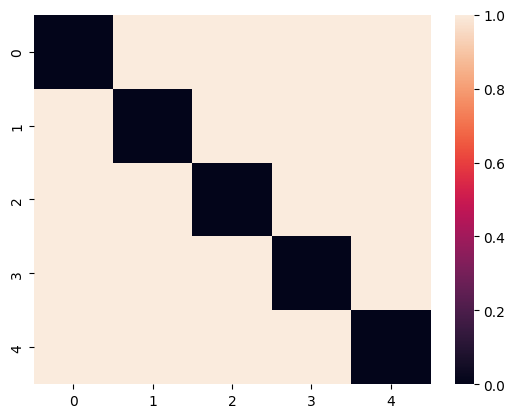

conditional_prior_dist  5 [0.26176454 0.37225983 0.096215   0.03908795 0.23067269]
individual_alphabet  ['0', '1', '2', '3', '4']


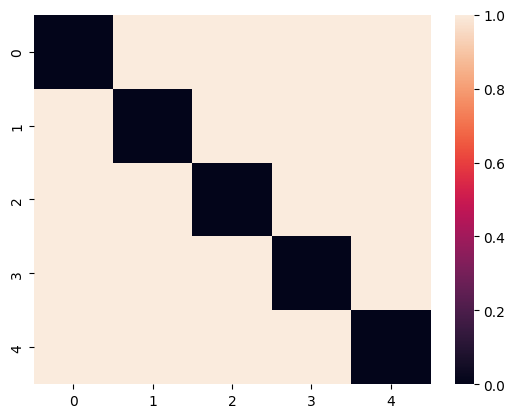

conditional_prior_dist  5 [0.04728991 0.37272504 0.00651783 0.53978848 0.03367875]
conditional_prior_dist  5 [0.00402998 0.00872865 0.05129814 0.00239496 0.93354827]
conditional_prior_dist  5 [0.26701057 0.00516411 0.51497806 0.19339836 0.01944889]
conditional_prior_dist  5 [0.09802482 0.59720538 0.0185903  0.13811854 0.14806097]
conditional_prior_dist  5 [0.9210198  0.03441566 0.03581362 0.00302859 0.00572232]
alphabet  25 [[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]
 [1 0]
 [1 1]
 [1 2]
 [1 3]
 [1 4]
 [2 0]
 [2 1]
 [2 2]
 [2 3]
 [2 4]
 [3 0]
 [3 1]
 [3 2]
 [3 3]
 [3 4]
 [4 0]
 [4 1]
 [4 2]
 [4 3]
 [4 4]]
alphabet_dict  2 {'0': array([0, 1, 2, 3, 4]), '1': array([0, 1, 2, 3, 4])}
prior_dist  25 [0.01237882 0.0975662  0.00170614 0.14129748 0.0088159  0.0015002
 0.00324933 0.01909624 0.00089155 0.34752252 0.02569042 0.00049686
 0.04954861 0.01860782 0.00187128 0.00383159 0.02334353 0.00072666
 0.00539877 0.0057874  0.21245411 0.00793875 0.00826122 0.00069861
 0.00131998]
individual_alphabet  ['0'

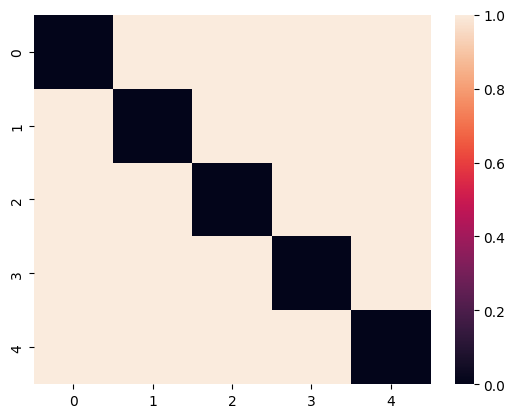

conditional_prior_dist  5 [0.2 0.2 0.2 0.2 0.2]
individual_alphabet  ['0', '1', '2', '3', '4']


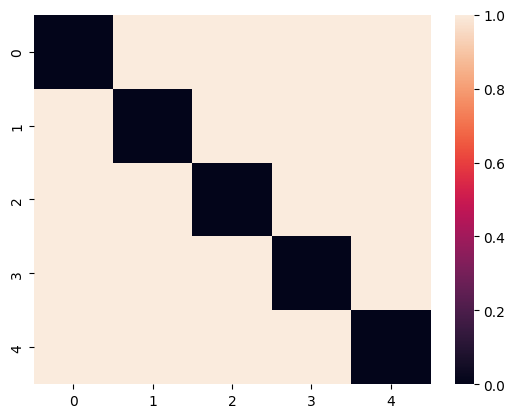

conditional_prior_dist  5 [0.2 0.2 0.2 0.2 0.2]
conditional_prior_dist  5 [0.2 0.2 0.2 0.2 0.2]
conditional_prior_dist  5 [0.2 0.2 0.2 0.2 0.2]
conditional_prior_dist  5 [0.2 0.2 0.2 0.2 0.2]
conditional_prior_dist  5 [0.2 0.2 0.2 0.2 0.2]
2.45960311115695
0.6857716622501423 0.008673162111374444
0.7013079984463965 0.004765838957298404
eps list  0.9 [0.5406768760295376, 0.49597811372954176]
0.45
0.45
0.45
0.45
0.45
0.45
0.5406768760295376
0.49597811372954176
0.49597811372954176
0.49597811372954176
0.49597811372954176
0.49597811372954176
0.9
0.9
0.9
0.9
0.9
0.9
6.0496474644129465
0.6857716622501423 0.008673162111374444
0.7013079984463965 0.004765838957298404
eps list  1.8 [1.0751346919390221, 0.9531284065010242]
1.0751346919390221
0.9531284065010242
0.9531284065010242
0.9531284065010242
0.9531284065010242
0.9531284065010242
1.8
1.8
1.8
1.8
1.8
1.8
14.879731724872837
0.6857716622501423 0.008673162111374444
0.7013079984463965 0.004765838957298404
eps list  2.7 [1.6182525214954597, 1.374588

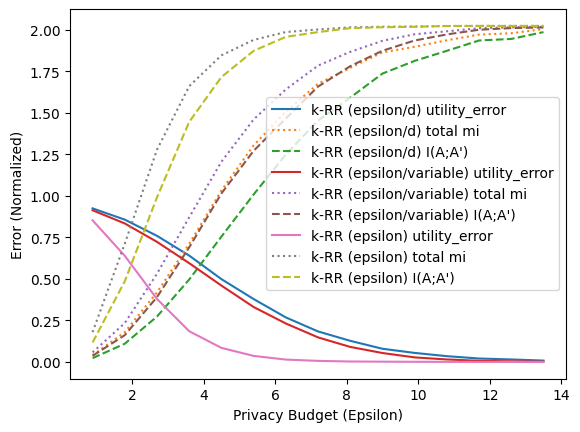

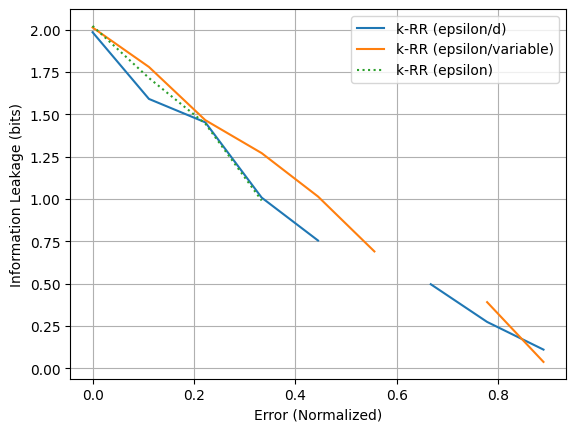

In [ ]:
utility_error_function = ["0_1"] # ["0_1", "l1", "l2"]
line_styles = {"RAPPOR": ":", "k-RR as one group": "--", "Exponential": "-.", "Approx. Solution": "-", "optimal": ":", "k-RR (epsilon/d)": "-", "k-RR (epsilon)": ":", "k-RR (epsilon/variable)": "-"}

for util_err in utility_error_function:
    alphabet_value_dict = {}
    for i in range(len(ALL_ALPHABET)):
        alphabet_value_dict[str(ALL_ALPHABET[i])] = i
    print(alphabet_value_dict)
    normalize_error_matrix = Normalize_error_matrix(attribute_list=ATTRIBUTE_LIST, alphabet=ALL_ALPHABET, priority_dict=priority_dict, alphabet_dict=alphabet_value_dict, err_type=util_err)
    err_matrix = normalize_error_matrix.normalized_error_matrix
    # sns.heatmap(err_matrix)
    # plt.show()

    # exponential_mechanism_without_prior = Exponential_mechanism(prior_dist=random_dist, STATE_COUNT=TOTAL_STATES, INPUT_ALPHABET=STRING_ALL_ALPHABET, normalized_objective_err_matrix=err_matrix, only_err_matrix=True)

    # exponential_mechanism_with_prior = Exponential_mechanism(prior_dist=random_dist, STATE_COUNT=TOTAL_STATES, INPUT_ALPHABET=STRING_ALL_ALPHABET, normalized_objective_err_matrix=err_matrix, only_err_matrix=False)
    optimal_random_response_mechanism = Optimized_Randomized_Response(prior_dist = random_dist, STATE_COUNT = TOTAL_STATES, INPUT_ALPHABET = STRING_ALL_ALPHABET, normalized_objective_err_matrix = err_matrix, 
                    TOLERANCE_MARGIN = 0.01, APPROXIMATION = "LINEAR", solver = "SCS", is_kl_div = True, ALPHA=0.01, accelerate_from_rr=True)

    random_response_mechanism = Randomized_Response(STATE_COUNT=TOTAL_STATES, INPUT_ALPHABET=STRING_ALL_ALPHABET, normalized_objective_err_matrix=err_matrix)
    optimal_mechanism_list = create_optimal_mechnism_dict(alphabet=ALL_ALPHABET, alphabet_dict=alphabet_dict, prior_dist=random_dist, err_type=util_err)
    optimal_mechanism_list_divided = create_optimal_mechnism_dict(alphabet=ALL_ALPHABET, alphabet_dict=alphabet_dict, prior_dist=random_dist, err_type=util_err, uniform=True)

    # rappor_mechanism = Rappor_mechanism(STATE_COUNT=TOTAL_STATES, INPUT_ALPHABET = STRING_ALL_ALPHABET, prob_f=0.5, prob_p=0.25, prob_q=0.75, collection_count = 20)
    # mechanisms_dict = {"Exp. mechanism without prior": exponential_mechanism_without_prior, "Exp. mechanism with prior": exponential_mechanism_with_prior, "k-RR": random_response_mechanism, "Optimal k-RR": optimal_random_response_mechanism}
    # mechanisms_dict = {"k-RR": random_response_mechanism, "Optimal k-RR": optimal_random_response_mechanism}
    # mechanisms_dict = {"RAPPOR": rappor_mechanism, "k-RR": random_response_mechanism, "Exponential": exponential_mechanism_without_prior, "Our": optimal_random_response_mechanism}
    # mechanisms_dict = {"k-RR": random_response_mechanism, "Our": optimal_mechanism_list, "k-RR_divided": optimal_mechanism_list_divided, "k-RR_non_divided": optimal_mechanism_list_divided, "optimal": optimal_random_response_mechanism}
    mechanisms_dict = {"k-RR (epsilon/d)": optimal_mechanism_list_divided, "k-RR (epsilon/variable)": optimal_mechanism_list_divided, "k-RR (epsilon)": optimal_mechanism_list_divided}#, "Approx. Solution": optimal_mechanism_list}

    error_dict = {}
    mi_dict = {}
    total_mi_dict = {}

    for key in list(mechanisms_dict.keys()):
        error_dict[key] = []
        mi_dict[key] = []
        total_mi_dict[key] = []

    for eps in EPS_ARRAY:
        eps_list = cal_eps_values(eps)
        print("eps list ", eps, eps_list)
        # print(eps)
        for mechanism in list(mechanisms_dict.keys()):
            __tot_error = 0
            __perturbed_value_list = []
            for entry in correlated_synthetic_dataset:
                # entry = entry_np_value[0]
                if mechanism == "Approx. Solution":
                    __perturbed_value_list.append(get_randomized_value(actual_value=entry, eps=eps, mechanism_list=optimal_mechanism_list))
                    # print("__perturbed_value_list ", __perturbed_value_list[-1])
                elif mechanism == "k-RR (epsilon/d)":
                    __perturbed_value_list.append(get_randomized_value(actual_value=entry, eps=eps/NUM_ATTRIBUTES, mechanism_list=optimal_mechanism_list_divided))
                    # print("__perturbed_value_list ", __perturbed_value_list[-1])
                elif mechanism == "k-RR (epsilon)":
                    __perturbed_value_list.append(get_randomized_value(actual_value=entry, eps=eps, mechanism_list=optimal_mechanism_list_divided))
                elif mechanism == "k-RR (epsilon/variable)":
                    
                    __perturbed_value_list.append(get_randomized_value(actual_value=entry, eps=eps_list, mechanism_list=optimal_mechanism_list_divided))
                    # print("__perturbed_value_list ", __perturbed_value_list[-1])
                elif mechanism == "RAPPOR":
                    __perturbed_value_list.append(mechanisms_dict[mechanism].gen_random_output(actual_value=entry, eps=eps, prob_f=eps/10, is_eps=True)[0])
                else:
                    # print(mechanism)
                    __perturbed_value_list.append(mechanisms_dict[mechanism].gen_random_output(actual_value=entry, eps=eps)[0])
                # print(entry,__perturbed_value_list[-1])
                __error = normalize_error_matrix.get_value_error(actual=entry, perturbed=__perturbed_value_list[-1])
                __tot_error += __error
            error_dict[mechanism].append(__tot_error/len(correlated_synthetic_dataset))
            # mi_dict[mechanism].append(mutual_info_pair(correlated_synthetic_dataset, __perturbed_value_list))
            # local_mi(__perturbed_value_list)
            # total_mi_dict[mechanism].append(total_info_leakage(correlated_synthetic_dataset, __perturbed_value_list, ))
            mi_dict[mechanism].append(mutual_information(correlated_synthetic_dataset, __perturbed_value_list))
    # fig, axs = plt.subplot()
    # ax2 = axs.twinx()
    lagends = []
    for mechanism in list(mechanisms_dict.keys()):
        lagends.append(mechanism + " utility_error")
        plt.plot(EPS_ARRAY, error_dict[mechanism])
        lagends.append(mechanism + " total mi")
        lagends.append(mechanism + " I(A;A')")
        plt.plot(EPS_ARRAY, np.array(mi_dict[mechanism])[:,0], linestyle=":")
        plt.plot(EPS_ARRAY, np.array(mi_dict[mechanism])[:,1], linestyle="--")
    # ax2.set_ylabel("Information Leakage (Bits)")
    plt.legend(lagends)
    plt.xlabel("Privacy Budget (Epsilon)")
    plt.ylabel("Error (Normalized)")
    # plt.title(f"{error_cal_type} error between original value and perturbed value for {Attr_list}")
    plt.show()

    utility_error = np.arange(10)
    
    utility_error = utility_error/np.max(utility_error)

    tolerance = (utility_error[1] - utility_error[0])/2

    info_dict = {}

    for mechanism in list(mechanisms_dict.keys()):
        info_dict[mechanism] = []
        for i in utility_error:
            info_dict[mechanism].append(np.nan)

    for index_1, i in enumerate(utility_error):
        for mechanism in list(mechanisms_dict.keys()):
            acquired_indexes = []
            min_dist = tolerance
            acquired_index = -1
            for index_, j in enumerate(error_dict[mechanism]):
                if (index_ not in acquired_indexes) and  abs(i-j) <= min_dist:
                    min_dist = abs(i-j)
                    acquired_index = index_
                    info_dict[mechanism][index_1] = (np.array(mi_dict[mechanism])[:,1][index_])
                    # break
            if acquired_index != -1:
                acquired_indexes.append(acquired_index)
    
    fig = plt.figure()
    lagends = []
    for mechanism in list(mechanisms_dict.keys()):
        lagends.append(mechanism)
        plt.plot(utility_error, info_dict[mechanism], linestyle=line_styles[mechanism])
    plt.xlabel("Error (Normalized)") 
    plt.ylabel("Information Leakage (bits)")
    plt.legend(lagends)
    plt.grid(visible=True)
    plt.show()
    fig.savefig(f"{util_err}new.pdf", bbox_inches='tight')


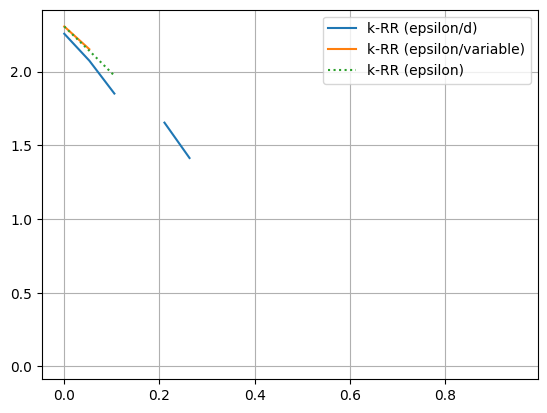

In [ ]:
utility_error = np.arange(20)
    
utility_error = utility_error/np.max(utility_error)

tolerance = (utility_error[1] - utility_error[0])/2

info_dict = {}

for mechanism in list(mechanisms_dict.keys()):
    info_dict[mechanism] = []
    for i in utility_error:
        info_dict[mechanism].append(np.nan)

for index_1, i in enumerate(utility_error):
    for mechanism in list(mechanisms_dict.keys()):
        acquired_indexes = []
        min_dist = tolerance
        acquired_index = -1
        for index_, j in enumerate(error_dict[mechanism]):
            if (index_ not in acquired_indexes) and  abs(i-j) <= min_dist:
                min_dist = abs(i-j)
                acquired_index = index_
                info_dict[mechanism][index_1] = (np.array(mi_dict[mechanism])[:,1][index_]) #(mi_dict[mechanism][index_])
                # break
        if acquired_index != -1:
            acquired_indexes.append(acquired_index)
    
fig = plt.figure()
lagends = []
for mechanism in list(mechanisms_dict.keys()):
    lagends.append(mechanism)
    plt.plot(utility_error, info_dict[mechanism], linestyle=line_styles[mechanism])

plt.legend(lagends)
plt.grid(visible=True)
plt.show()
fig.savefig(f"{util_err}.pdf", bbox_inches='tight')
